In [190]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"
%autoreload 2
import pandas as pd
pd.set_option("display.precision",2)

# Heating Model
This notebook uses the weather and consumption data we have from 2015-2018 to build a simple linear heating model for the house.  

The model is, simply put, too simple.  Here are the major failings:
  - DHW load is probably a huge fraction of the base load.  But many of these measure could reduce it.  
  - Passive solar gain is neglected.
  - Simply subtracting average base load is a gross oversimplification.
  
Both of these are amenable to refinement, given sufficient time.  

In [192]:
# Load the data we have
import pandas as pd
data = pd.read_pickle('wxhydro2018.pickle')

## Determine baseline electrical consumption
The house's electrical consumption is shown in the center histogram below.  It's a very obvious bimodal distribution, that looks a lot like a mixture of gaussians, and I intuitively know what it means: there is a significant base load (centered on the left peak), and a very separate heating load (centered on the right peak).

#### Known base load
Fortunately, we have an easy way to learn a lot about the base-load -- I happen to know that in this house, essentially no mechanical heating or cooling is ever required when the OAT is between 16C and 20C (and actually a fair bit outside of that range), so we will use that to discover our baseline.  Most of it is domestic hot water, which is quite random.  But there are also some lights, computers, and other appliances.  To make things easier to handle, we'll plot the non-heating consumption on the basis of a 24-hr sliding-window average.  The left plot shows our averaged no-heat power data.  Sure enough, it looks like a slightly skewed gaussian, with a nice little low-load peak on the left that probably indicates the load during unoccupied periods longer than a day.

#### First guess at heating load
These two distributions are so distinct that it's pretty easy to imagine that they're gaussians and visually disentangle them.  By inspection, we have a pretty good idea that the mean base load is 1.1 kW, and the mean total load *when there is heating active* is 2.4 kW.  By looking at the relative areas of the two peaks, it's pretty clear that there are a lot more data points at base load than with heating active.

A good first guess would be to subtract the mean of our *known* base load.  This is quite obviously not a great fit -- it commingles a lot of base load points with the heating load, and our resulting heating model will be quite a bit on the low side.

A good second estimate is to *filter* that plot to remove points that we suspect are probably base load.  This has the opposite problem -- it will remove a lot of low-power heating points, biasing our model on the high side.

#### Heating load

The plot on the right shows the distribution of (power minus baseload), or as we're now calling it, heating load.

In [193]:
# Compute load series

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Set up the data we'll be using
# Rolling averages
data['OATAvg'] = data['OAT'].rolling(24).mean()
data['consAvg'] = data['cons'].rolling(24).mean()
#baseline=data[(data.OATAvg>=16)&(data.OATAvg<=22)] # Using calendar instead
baseline = data[(data.index.dayofyear>=167)&(data.index.dayofyear<259)] # Summer: June 15 - Sept 14
winter = data[(data.index.dayofyear<167)|(data.index.dayofyear>=259)] # Non-summer


#Compute 
meanbaseload = np.mean(baseline.consAvg)
std = np.sqrt(np.var(baseline.consAvg))
baseload = (meanbaseload + 2.5 * std)
#baseload = meanbaseload 

# Print mean, stddev, and baseload
print("Mean: %.2f kW StdDev: %.2f"%(meanbaseload,std) )
print("Offset: %.2f kW Baseload: %.2f kW" % (2.7*std,baseload))

# Calculated series
data['hmloadAvg']=data.eval('(consAvg - @meanbaseload)*(consAvg>=@meanbaseload)')
data['hloadAvg']=data.eval('(consAvg - @baseload)*(consAvg>=@baseload)')
data['hfloadAvg']=data.eval('(consAvg - @meanbaseload)*(consAvg>=@baseload)')
data['hload']=data.eval('(cons - @baseload)*(cons>@baseload)')

Mean: 1.13 kW StdDev: 0.27
Offset: 0.73 kW Baseload: 1.80 kW


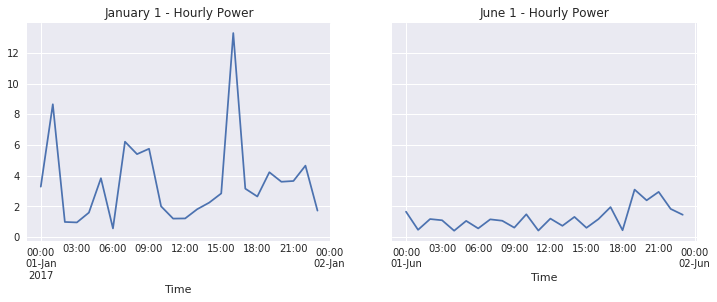

In [194]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,4),sharey=True)
ha = data.cons['2017-1-01'].plot(ax=axes[0])
ha.set_xlabel("Time")
ha.title.set_text('January 1 - Hourly Power')

ha = data.cons['2016-06-01'].plot(ax=axes[1])
ha.set_xlabel("Time")
ha.set_ylabel("Average power(kW)")
ha.title.set_text('June 1 - Hourly Power')


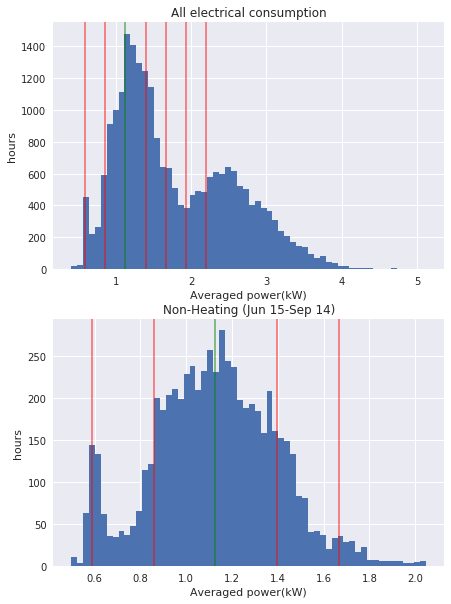

In [195]:
# Plot consumption and load histograms

def allpower(a):
    ha = data.consAvg.hist(bins=60,ax=a)
    ha.set_xlabel("Averaged power(kW)")
    ha.set_ylabel("hours")
    ha.title.set_text('All electrical consumption')
    for devs in range(-2,5):
        if devs == 0: col = 'g'
        else: col='r'
        vl=ha.axvline(x=baseline.consAvg.mean()+devs*std, color=col, alpha=0.5)

def sumpow(a):
    baseline=data[(data.index.month==7)|(data.index.month==8)]
    ha = baseline.consAvg.hist(bins=60,ax=a)
    ha.set_xlabel("Averaged power(kW)")
    ha.set_ylabel("hours")
    ha.title.set_text('Non-Heating (Where 16-20C)')
    for devs in range(-2,3):
        if devs == 0: col = 'g'
        else: col='r'
        vl=ha.axvline(x=baseline.consAvg.mean()+devs*std, color=col, alpha=0.5)

def nonheat(a):
    ha = baseline.consAvg.hist(bins=60,ax=a)
    ha.set_xlabel("Averaged power(kW)")
    ha.set_ylabel("hours")
    ha.title.set_text('Non-Heating (Jun 15-Sep 14)')
    for devs in range(-2,3):
        if devs == 0: col = 'g'
        else: col='r'
        vl=ha.axvline(x=baseline.consAvg.mean()+devs*std, color=col, alpha=0.5)

def meanheat(a):
    mdshl= data['hmloadAvg'][data['hmloadAvg'].gt(0)]
    hlp = mdshl.hist(bins=60,ax=a)
    hlp.title.set_text('Heating (mean baseload of %.2f kW)'%meanbaseload)
    hlp.set_xlabel("Nonzero heating power")
    hlp.set_ylabel("hours at power")

def baseheat(a):
    # Plot agg cons
    dshl= data['hfloadAvg'][data['hfloadAvg'].gt(0)]
    binrange=np.arange(0.0,4.0,5/60)
    hlp = dshl.hist(bins=binrange,ax=a)
    hlp.title.set_text('Heating ( baseload of %.2f kW)'%baseload)
    hlp.set_xlabel("Nonzero heating power (filtered)")
    hlp.set_ylabel("hours at power")


def plot4():
    # Set up the 4-plot figure
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    allpower(axes[0,0])
    nonheat(axes[0,1])
    #sumpow(axes[0,1])
    meanheat(axes[1,0])
    baseheat(axes[1,1])

def plot3():
    # Set up the 4-plot figure
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
    fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    allpower(axes[0])
    nonheat(axes[1])
    meanheat(axes[2])

def plot2():
    # Set up the figure
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,10))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    allpower(axes[0])
    nonheat(axes[1])
    #meanheat(axes[2])

def plotRes2():
    # Set up the figure
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,10))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    meanheat(axes[0])
    #baseheat(axes[1])
    #meanheat(axes[2])

def plotRes():
    # Set up the figure
    #fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,10))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    meanheat(axes[0])
    #baseheat(axes[1])
    #meanheat(axes[2])
    
    
plot2()
plt.show()

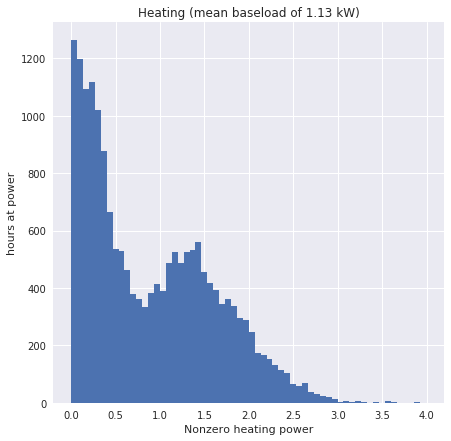

In [196]:

def plotRes2():
    # Set up the figure
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,10))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    meanheat(axes[0])
    #baseheat(axes[1])
    #meanheat(axes[2])

def plotRes():
    # Set up the figure
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
    #fig.suptitle("Heating vs Non-Heating Hourly consumption",size=14)
    meanheat(axes)
    #baseheat(axes[1])
    #meanheat(axes[2])
    
plotRes()
plt.show()

## GMM visualization

Sometimes it's useful to see if there's obvious clustering.  Applying the sklearn Gaussian Mixture model to this data does indeed separate it roughly where we're suggesting -- somewhere along the 2 kW line.

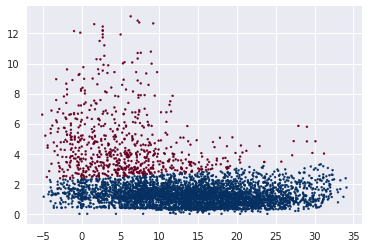

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

xt = data[['cons','OAT']]['2015'].fillna(0)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2,covariance_type="full").fit(xt)
labels = gmm.predict(xt)
plt.scatter(xt.OAT,xt.cons, c=labels, s=4,cmap='RdBu'); # , cmap='viridis'

## Scatter Plots
Now that we have a reasonable value for *heating load* for every hour over our study period, our next job is to treat that as a dependent variable, and figure out which independent variables influence it.  

Typical environmental factors influencing heating load are things like OAT, wind speed, and solar irradiance (which we unfortunately don't have for this study period).   There are human factors too, such as temperature setpoint and occupancy, but my house has a constant setpoint of 22C, and I have no occupancy data, so we'll have to neglect that.

A good way to discover pairwise relationships is to look at scatter plots.  So here are scatter plots of heating load (x-axis) against various weather data, for all points where heating load is non-zero.

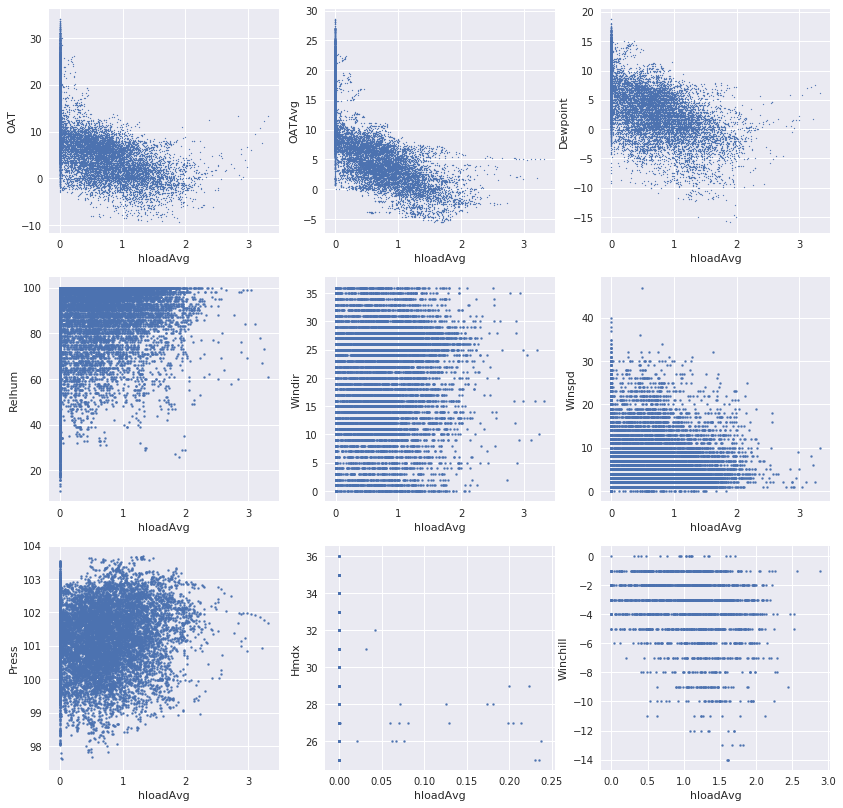

In [198]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(14,14))
COLS = ['OAT', 'OATAvg', 'Dewpoint','Relhum', 'Windir', 'Winspd', 'Press', 'Hmdx', 'Winchill']
r=0
s=1
for i in range (0,9):
    c=i%3
    colname=COLS[i]
    if r>0:
        s=4
    data.plot.scatter(x='hloadAvg',y=colname,ax=axes[r,c],s=s)
    if(c==2):
        r=r+1

## Visualize heating power versus Heating-degree-hours
It's clear in the scatter matrix that an inverse correlation with OAT is really the only significant weather relationship we have -- dewpoint is really too strongly linked to temperature to be useful, and we can see that there isn't much of a correlation with relative humidity.

It's common in the industry to straighten out this inverse correlation by using heating degree-days or degree-hours instead of temperature.  That's just the sum-product of hours below 18C.

The plot below shows a sliding window average of heating load versus HDHs.  It looks like a pretty good fit.

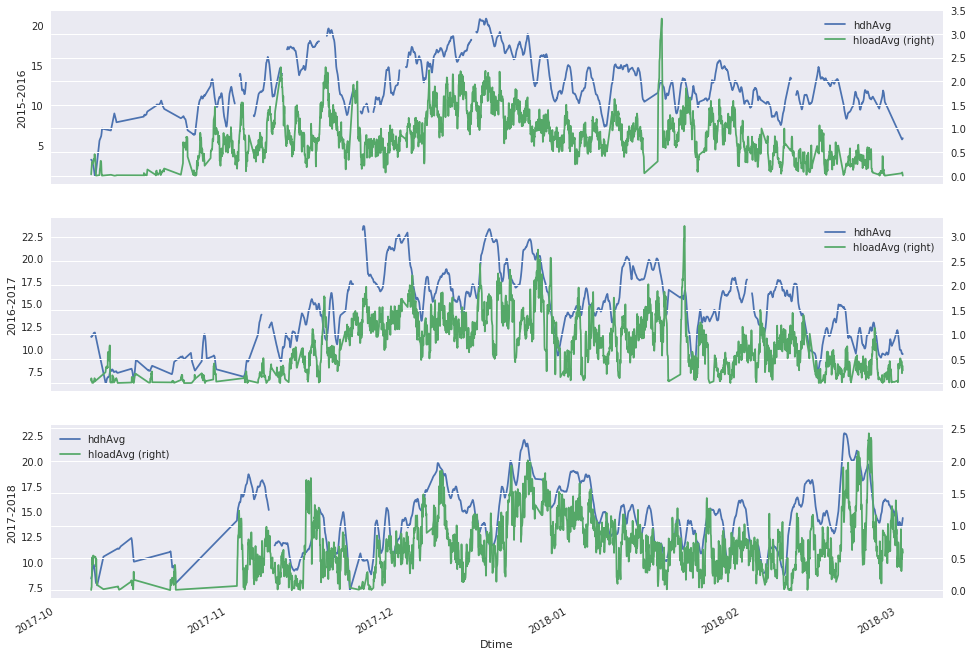

In [199]:
# Some weather stuff that we don't need
data['hdh']=data.eval('(18-OAT)*(18>OAT)')
data['hdhAvg']= data['hdh'].rolling(24).mean()

rs=[['20151001','20160401']
   ,['20161001','20170401']
   ,['20171001','20180301']]

pdata=data[data.hloadAvg>0][['hdhAvg','hloadAvg']]

fig,axes=plt.subplots(3,1,figsize=(16,12),sharex=False)
for i in range (0,3):
    yr=2015+i
    yd = pdata[rs[i][0]:rs[i][1]].sort_index()
    yd.plot(yd.index,secondary_y='hloadAvg',ax=axes[i])
    label = str(yr)+"-"+str(yr+1)
    axes[i].set_ylabel(label)
    #axes[i].plot(yd.hdh)
    #ax2=axes[i].twinx()
    #ax2.plot(yd.hloadAvg,'g-')


## Linear Regression
We are now reasonably confident that we now have a pretty good relationship between a trailing-window HDH and heating load.  The data is very noisy, so it's not practical to try to model the behaviour precisely.  A simple linear regression will probably be as good as anything else.

Here, we've run linear regressions against both the *filtered* and *unfiltered* estimates of heating load.  We know that one is biased high, and the other low, so for lack of enough time to do better, we'll just average them.

LinregressResult(slope=-0.09807603499526579, intercept=1.680749371087145, rvalue=-0.8163932970434911, pvalue=0.0, stderr=0.0005098736297828775)

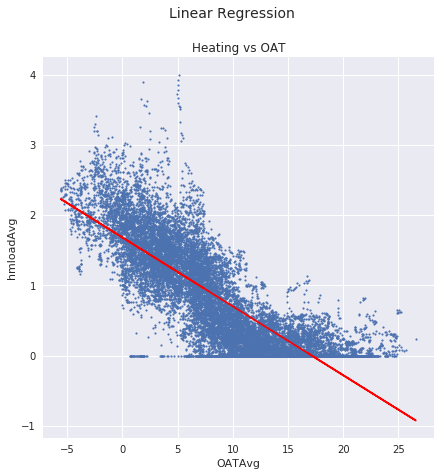

In [200]:
import scipy.stats as stats
def plot1(a):
    # Plot 1
    h2data=data[(data.hdh>0)][['OATAvg','hmloadAvg']].replace([np.inf,-np.inf],np.nan).dropna()
    lrr = stats.linregress(h2data.OATAvg,h2data.hmloadAvg)
    slope, intercept, r_value, p_value, std_err = lrr
    h2p = h2data.plot.scatter('OATAvg','hmloadAvg',s=3,ax=a)
    h2p.title.set_text('Heating vs OAT')

    f=lambda x: intercept + slope*x
    h2p.plot(h2data.OATAvg,f(h2data.OATAvg),c='r')
    x0 = -intercept/slope
    display(lrr)
    #print("X-intercept 1 is at y=%f kW"%f(0))
    #print("Y-intercept 1 is at x=%f °C OAT"%x0)
    return (intercept, slope)

def plot2(a):    
    # Plot 2
    h3data=data[(data.hdh>0)&(data.hfloadAvg>0)][['OATAvg','hfloadAvg']].replace([np.inf,-np.inf],np.nan).dropna()
    lrr = stats.linregress(h3data.OATAvg,h3data.hfloadAvg)
    slope, intercept, r_value, p_value, std_err = lrr
    h3p = h3data.plot.scatter('OATAvg','hfloadAvg',s=3,ax=a)
    h3p.title.set_text('Filtered heating: Linear regression against OAT')
    h3p.get_figure().suptitle("Linear regression of non-zero heating load against OAT")
    f=lambda x: intercept + slope*x
    h3p.plot(h3data.OATAvg,f(h3data.OATAvg),c='r')
    x0 = -intercept/slope
    display(lrr)
    #print("X-intercept 2 is at y=%f kW"%f(0))
    #print("Y-intercept 2 is at x=%f °C OAT"%x0)
    return (intercept, slope)

def plotw(a):    
    # Plot 3: Winter hloadAvg
    h3data=winter[['OATAvg','hloadAvg']].replace([np.inf,-np.inf],np.nan).dropna()
    lrr = stats.linregress(h3data.OATAvg,h3data.hloadAvg)
    slope, intercept, r_value, p_value, std_err = lrr
    h3p = h3data.plot.scatter('OATAvg','hloadAvg',s=3,ax=a)
    h3p.title.set_text('Filtered heating: Linear regression against OAT')
    h3p.get_figure().suptitle("Linear regression of non-zero heating load against OAT")
    f=lambda x: intercept + slope*x
    h3p.plot(h3data.OATAvg,f(h3data.OATAvg),c='r')
    x0 = -intercept/slope
    display(lrr)
    #print("X-intercept 2 is at y=%f kW"%f(0))
    #print("Y-intercept 2 is at x=%f °C OAT"%x0)
    return (intercept, slope)

def plotCompare():
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,7), sharey=True)
    fig.suptitle("Linear Regression",size=14)
    Heat01, HeatSlope1 = plot1(axes[0])
    Heat02, HeatSlope2 = plotw(axes[1])

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
fig.suptitle("Linear Regression",size=14)
Heat01, HeatSlope1 = plot1(axes)
#Heat02, HeatSlope2 = plotw(axes[1])

    
BaseThreshold=baseload
MeanBaseload=meanbaseload
#Heat0=(Heat01+Heat02)/2
#HeatSlope=(HeatSlope1+HeatSlope2)/2
Heat0=Heat01
HeatSlope=HeatSlope1
#Heat0=Heat01
#HeatSlope=HeatSlope1

### Heating model
So, the linear heating model we're going to use as a function of OAT in degC:

$HeatLoad = max(0, Heat0 + HeatSlope \times OAT)\:kW \\
Cons_{BAU} = (HeatLoad+BaseThreshold)\:kW$

In [201]:
#heat=lambda temp: Heat0 + HeatSlope*temp

print("Heat0=%.2f"% Heat0)
print("HeatSlope=%.3f"% HeatSlope)
print("BaseThreshold=%.2f"%BaseThreshold)
print("MeanBaseload=%.2f"%MeanBaseload)
tempAtHeat=lambda h: (h - Heat0)/HeatSlope
print("HeatCutoff=%.2f"%tempAtHeat(0.0))

Heat0=1.68
HeatSlope=-0.098
BaseThreshold=1.80
MeanBaseload=1.13
HeatCutoff=17.14


## Validation


In [204]:
# Validate
def doBAU(dfIn):
    #df = pd.DataFrame( dfIn.loc[dfIn.index.year == year] )
    df = dfIn
    df['hload'] = np.maximum(0, Heat0 + HeatSlope * dfIn.OAT )
    #df['bcons'] = df.hload + BaseThreshold # MeanBaseload
    df['bcons'] = dfIn.hload + MeanBaseload
    df['err'] = (df.cons - df.bcons) / df.cons *100
    return df

def valYears(df):
    for i in range(2015,2019):
        #df = doBAU(data,year=i)
        real = df.loc[df.index.year==i].cons.sum()
        model =  df.loc[df.index.year==i].bcons.sum()
        print("Year %d total consumption (kWh): Real %d Model %d Error %.1f%%"%(i,real,model,abs(100*(model-real)/real)))

df = doBAU(data)
valYears(df)

# Total error:
real = df.cons.sum()
model =  df.bcons.sum()

print("All years total consumption (kWh): Real %d Model %d Error %.1f%%"%(real,model,abs(100*(model-real)/real)))


Year 2015 total consumption (kWh): Real 8602 Model 8435 Error 1.9%
Year 2016 total consumption (kWh): Real 15624 Model 15823 Error 1.3%
Year 2017 total consumption (kWh): Real 15039 Model 16907 Error 12.4%
Year 2018 total consumption (kWh): Real 4331 Model 4396 Error 1.5%
All years total consumption (kWh): Real 43599 Model 45563 Error 4.5%


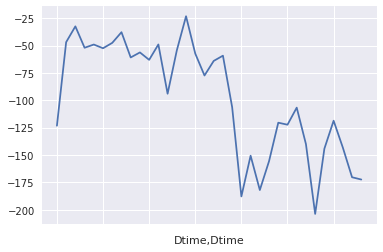

In [203]:
#hy.cons.groupby((hy.index.year,hy.index.month)).sum().plot(x=hy.index,y=hy.cons,figsize=(18,6))
df.err.groupby((df.index.year,df.index.month)).mean().plot(x=df.index,y=df.err)
#df.groupby((df.index.year,df.index.month)).mean().plot(x=df.index,y=['bcons'])

## Conclusions

We could clearly have a better heating model -- our error in 2017 is quite high.  I see two primary counfounding factors:

  1. I've used a naiive approach to defining "heating" data points.  As the baseload has a wide probability distribution, simply filtering out a "typical" baseload still leaves all of the baseload variability in the so-called "heating data."
  
  2. The domestic hot water load is entangled with the heating load, and I haven't done a good enough job of separating them.

Having a trustworthy heating model is key to making our following decisions, but perfecting it isn't really the purpose of this project.  For now, we'll proceed with what we've got.